In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 

path = "/content/data"
os.mkdir(path) 


In [4]:
import shutil

# shutil.copy("/content/drive/MyDrive/dataset/annotation.tar","/content/data/annotation.tar")
# shutil.copy("/content/drive/MyDrive/dataset/images.tar","/content/data/images.tar")
# shutil.copy("/content/drive/MyDrive/dataset/lists.tar", "/content/data/lists.tar")

shutil.unpack_archive("/content/drive/MyDrive/datasets/stanford_dogs/annotation.tar","/content/data")
shutil.unpack_archive("/content/drive/MyDrive/datasets/stanford_dogs/images.tar","/content/data")
shutil.unpack_archive("/content/drive/MyDrive/datasets/stanford_dogs/lists.tar", "/content/data")

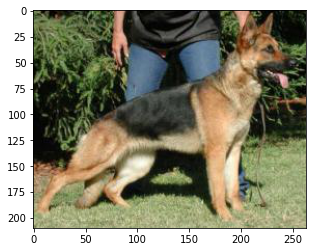

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('/content/data/Images/n02106662-German_shepherd/n02106662_11808.jpg')

imgplot = plt.imshow(img)

In [6]:
from PIL import Image
from os.path import join
import os
import scipy.io
import collections
import torch.utils.data as data
from torchvision.datasets.utils import download_url, list_dir, list_files
from xml.etree.ElementTree import Element as ET_Element
try:
    from defusedxml.ElementTree import parse as ET_parse
except ImportError:
    from xml.etree.ElementTree import parse as ET_parse

In [7]:
COCO_INSTANCE_CATEGORY_NAMES = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'flat-coated_retriever', 'curly-coated_retriever', 'golden_retriever', 'Labrador_retriever', 'Chesapeake_Bay_retriever', 'German_short-haired_pointer', 'vizsla', 'English_setter', 'Irish_setter', 'Gordon_setter', 'Brittany_spaniel', 'clumber', 'English_springer', 'Welsh_springer_spaniel', 'cocker_spaniel', 'Sussex_spaniel', 'Irish_water_spaniel', 'kuvasz', 'schipperke', 'groenendael', 'malinois', 'briard', 'kelpie', 'komondor', 'Old_English_sheepdog', 'Shetland_sheepdog', 'collie', 'Border_collie', 'Bouvier_des_Flandres', 'Rottweiler', 'German_shepherd', 'Doberman', 'miniature_pinscher', 'Greater_Swiss_Mountain_dog', 'Bernese_mountain_dog', 'Appenzeller', 'EntleBucher', 'boxer', 'bull_mastiff', 'Tibetan_mastiff', 'French_bulldog', 'Great_Dane', 'Saint_Bernard', 'Eskimo_dog', 'malamute', 'Siberian_husky', 'affenpinscher', 'basenji', 'pug', 'Leonberg', 'Newfoundland', 'Great_Pyrenees', 'Samoyed', 'Pomeranian', 'chow', 'keeshond', 'Brabancon_griffon', 'Pembroke', 'Cardigan', 'toy_poodle', 'miniature_poodle', 'standard_poodle', 'Mexican_hairless', 'dingo', 'dhole', 'African_hunting_dog']

class BreedDogsDataset(object):
    folder = 'data'
    def __init__(self, root, train=True,transforms=None):
        self.root = join(os.path.expanduser(root), self.folder)
        self.train = train
        self.transforms = transforms
        self.annotations = self.load_split()
        self.images_folder = join(self.root, 'Images')
        self.annotations_folder = join(self.root, 'Annotation')
        self.breeds = list_dir(self.images_folder)
        # self.imgs = [(annotation + '.jpg', idx) for annotation, idx in self.annotations]
        self.imgs = [ annotation + '.jpg'  for annotation, _ in self.annotations]
        self.imgs = sorted(self.imgs)

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.images_folder, self.imgs[idx])
        # mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        dic = self.parse_voc_xml(ET_parse(self.annotations_folder + '/' + self.annotations[idx][0]).getroot())
        target = self.target_form_trans(dic, idx)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def target_form_trans(self, dic, index):
        dic = dic['annotation']

        image_id = torch.tensor([index])
        target = {}
        target["boxes"] = []
        target["labels"] = []
        target["image_id"] = image_id
        target["area"] = []
        target["iscrowd"] = []

        boxes = []
        labels = []

        if 'object' not in dic:
            return target

        if isinstance(dic['object'], list):
            num_objs = len(dic['object'])
        elif isinstance(dic['object'], dict):
            num_objs = 1
        else:
            num_objs = 0

        # if num_objs == 1:
        #     xmin = np.int32(dic['object']['bndbox']['xmin'])
        #     xmax = np.int32(dic['object']['bndbox']['xmax'])
        #     ymin = np.int32(dic['object']['bndbox']['ymin'])
        #     ymax = np.int32(dic['object']['bndbox']['ymax'])

        #     label = 0
        #     obj_name = dic['object']['name']

        #     if obj_name in COCO_INSTANCE_CATEGORY_NAMES:
        #         label = np.int64(COCO_INSTANCE_CATEGORY_NAMES.index(obj_name))

        #     boxes.append([xmin, ymin, xmax, ymax])
        #     labels.append(label)
        # else:
        for i in range(num_objs):
            xmin = np.int32(dic['object'][i]['bndbox']['xmin'])
            xmax = np.int32(dic['object'][i]['bndbox']['xmax'])
            ymin = np.int32(dic['object'][i]['bndbox']['ymin'])
            ymax = np.int32(dic['object'][i]['bndbox']['ymax'])

            label = 0
            obj_name = dic['object'][i]['name']
            if obj_name in COCO_INSTANCE_CATEGORY_NAMES:
                label = np.int64(COCO_INSTANCE_CATEGORY_NAMES.index(obj_name))

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return target

    def parse_voc_xml(self, node: ET_Element):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

    def load_split(self):
        if self.train:
            # print(f"directorio lista de entrenamiento: {self.root}")
            split = scipy.io.loadmat(join(self.root, 'train_list.mat'))['annotation_list']
            # print(split)
            labels = scipy.io.loadmat(join(self.root, 'train_list.mat'))['labels']
            # print(labels)
        else:
            split = scipy.io.loadmat(join(self.root, 'test_list.mat'))['annotation_list']
            labels = scipy.io.loadmat(join(self.root, 'test_list.mat'))['labels']

        split = [item[0][0] for item in split]
        labels = [item[0]-1 for item in labels]
        return list(zip(split, labels))

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import random
import os
import numpy as np
import torch
import torch.utils.data
from torchvision.transforms import functional as F
from collections import defaultdict, deque
import datetime
import pickle
import time
import math
import numbers
import warnings
from enum import Enum
from torch import Tensor
from typing import List, Tuple, Any, Optional
import sys

import torch.distributed as dist

import errno

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)

class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = self.delimiter.join([
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}',
            'max mem: {memory:.0f}'
        ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                print(log_msg.format(
                    i, len(iterable), eta=eta_string,
                    meters=str(self),
                    time=str(iter_time), data=str(data_time),
                    memory=torch.cuda.max_memory_allocated() / MB))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))

def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for image, targets in metric_logger.log_every(data_loader, 100, header):
        image = list(img.to(device) for img in image)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(image)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target

def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    print(model)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    print(model)
    return model

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

In [9]:
breeds_dogs_train_dataset = BreedDogsDataset('/content', train=True, transforms=get_transform(train=True))
breeds_dogs_test_dataset = BreedDogsDataset('/content', train=False, transforms=get_transform(train=False)) 
 
print(len(breeds_dogs_train_dataset))
print(len(breeds_dogs_test_dataset))

print(breeds_dogs_train_dataset[0])

12000
8580
(tensor([[[0.5804, 0.5804, 0.5804,  ..., 0.3608, 0.3608, 0.3608],
         [0.5804, 0.5804, 0.5804,  ..., 0.3647, 0.3608, 0.3608],
         [0.5804, 0.5804, 0.5804,  ..., 0.3647, 0.3647, 0.3608],
         ...,
         [0.5961, 0.5922, 0.5843,  ..., 0.3216, 0.3216, 0.3216],
         [0.5922, 0.5961, 0.6000,  ..., 0.3255, 0.3176, 0.3137],
         [0.5922, 0.5961, 0.6000,  ..., 0.3255, 0.3176, 0.3137]],

        [[0.7020, 0.7020, 0.7020,  ..., 0.3686, 0.3686, 0.3686],
         [0.7020, 0.7020, 0.7020,  ..., 0.3725, 0.3686, 0.3686],
         [0.7020, 0.7020, 0.7020,  ..., 0.3725, 0.3725, 0.3686],
         ...,
         [0.6863, 0.6824, 0.6745,  ..., 0.3412, 0.3412, 0.3412],
         [0.6824, 0.6863, 0.6902,  ..., 0.3451, 0.3373, 0.3333],
         [0.6824, 0.6863, 0.6902,  ..., 0.3451, 0.3373, 0.3333]],

        [[0.8235, 0.8235, 0.8235,  ..., 0.3569, 0.3569, 0.3569],
         [0.8235, 0.8235, 0.8235,  ..., 0.3608, 0.3569, 0.3569],
         [0.8235, 0.8235, 0.8235,  ..., 0.3608

In [10]:
import torch.utils.data

def collate_fn(batch):
    return tuple(zip(*batch))


data_loader_train = torch.utils.data.DataLoader(
        breeds_dogs_train_dataset, batch_size=4, shuffle=True, num_workers=4,
        collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        breeds_dogs_test_dataset, batch_size=4, shuffle=False, num_workers=4,
        collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [11]:
  num_classes = 120

  # get the model using our helper function
  model = build_model(num_classes)
  # move model to the right device
  model.to(device)

  # construct an optimizer
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=0.005,
                              momentum=0.9, weight_decay=0.0005)

  # and a learning rate scheduler which decreases the learning rate by
  # 10x every 3 epochs
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                  step_size=3,
                                                  gamma=0.1)
  
  # number of epochs
  num_epochs = 10
  #start training
  for epoch in range(num_epochs):
      # train for one epoch, printing every 10 iterations
      train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
      # update the learning rate
      lr_scheduler.step()
      # evaluate on the test dataset
      evaluate(model, data_loader_test, device=device)
  
  # save trained model for inference    
  torch.save(model, './output/faster-rcnn-beagle.pt')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU

NameError: ignored